In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/강의 자료들/2025/250701 인사교 6기 자연어처리 B반/딥러닝 기초 25.07.11 (class 2)

/content/drive/.shortcut-targets-by-id/1BetU2RLJA7gC3DgSstzRg0db8buEhQBE/딥러닝 기초 25.07.11 (class 2)


In [3]:
!pip -q install transformers[torch] datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.6 MB/s eta 0:00:00


## 목표
- 한국어 분류 데이터셋 활용해서, 한국어 토픽 분류 모델 구현

## 시나리오

### 배경
- “스마트뉴스”는 <u>월간 **12만 건** 이상의 뉴스 헤드라인</u>을 처리하는 AI 기반 토픽 분류 플랫폼  
- YNAT 데이터셋(연합뉴스 헤드라인, 7개 주제)으로 학습된 일반 사전학습 모델은 <u>**도메인별 뉘앙스**</u>와 <u>**언론사별 어투**</u>를 구분하기 어려움  
- <u>**Fine-Tuning**</u>을 통해 KoELECTRA 기반 분류 모델을 <u>**IT·과학, 경제, 사회 등 7개 주제**</u>에 최적화해야 하는 과제 존재  

```python
# 주요 이해관계자
- NLP 연구팀         : 사전학습 모델 파인튜닝 및 하이퍼파라미터 튜닝  
- 데이터 엔지니어팀   : YNAT 데이터 로딩·전처리·토크나이저 적용 파이프라인 구축  
- 제품 기획팀         : 토픽 분류 서비스 요구사항 정의 및 결과 활용 방안 수립  
- DevOps/운영팀      : T4 GPU 환경에서 모델 학습·배포·모니터링 자동화  
- QA/테스트팀        : 분류 정확도 검증 및 혼동행렬 기반 개선 포인트 제안  
```

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

In [6]:
from datasets import load_dataset

| Task  | 예시 인스턴스 (train) 주요 필드                          | 설명                                                         |
|-------|--------------------------------------------------------|------------------------------------------------------------|
| **ynat** (Topic Classification) | `guid`, `title`, `label`, `date`, `url`                 | 연합뉴스 기사 제목을 7개 주제(0–6)로 분류                          |
| **sts** (Semantic Textual Similarity) | `guid`, `sentence1`, `sentence2`, `labels`               | 두 문장 간 의미 유사도 (float 점수, real-label, binary-label)    |
| **nli** (Natural Language Inference)   | `guid`, `premise`, `hypothesis`, `label`                 | 전제(premise)와 가설(hypothesis) 간 함의 관계(0: entailment, 1: neutral, 2: contradiction)  |
| **ner** (Named Entity Recognition)     | `sentence`, `tokens`, `ner_tags`                         | 문장 문자 단위 토큰별 개체명 태그 (B-*/I-*/O)                     |
| **re** (Relation Extraction)           | `guid`, `sentence`, `subject_entity`, `object_entity`, `label` | 문장 속 두 개체(subject/object) 간 관계 분류                       |
| **dp** (Dependency Parsing)            | `sentence`, `index`, `word_form`, `lemma`, `pos`, `head`, `deprel` | 형태소 단위 의존 구문 분석 (head, deprel)                        |
| **mrc** (Machine Reading Comprehension) | `title`, `context`, `question`, `answers`, `is_impossible`, `news_category` | 지문(context)과 질문(question)에 대한 정답(answer) 스팬 추출      |
| **wos** (Dialogue State Tracking)      | `guid`, `domains`, `dialogue`                            | 대화(turn)별 사용자·시스템 발화와 상태(state) 추적                   |

In [7]:
raw_datasets = load_dataset("klue", "ynat")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.17M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/847k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

In [8]:
raw_datasets.keys()

dict_keys(['train', 'validation'])

In [9]:
raw_datasets["train"][0]

{'guid': 'ynat-v1_train_00000',
 'title': '유튜브 내달 2일까지 크리에이터 지원 공간 운영',
 'label': 3,
 'url': 'https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947',
 'date': '2016.06.30. 오전 10:36'}

In [10]:
raw_datasets["train"].to_pandas()
# 0번 IT, 과학
# 1번 경제
# 2번 사회
# 3번 생활, 문화
# 4번 세계
# 5번 스포츠
# 6번 정치

,guid,title,label,url,date
0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.05.08. 오전 5:25
2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.15. 오후 12:00
3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D...,2017.02.28. 오전 9:54
4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.04.03. 오전 7:05
...,...,...,...,...,...
45673,ynat-v1_train_45673,사우디 아람코 주요 석유시설·유전 드론 공격에 화재,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.09.14. 오후 4:36
45674,ynat-v1_train_45674,박기원 감독 눈치 보지 말고…비예나 눈치 본 건 아닌데,5,https://sports.news.naver.com/news.nhn?oid=001...,2019.11.03 17:06
45675,ynat-v1_train_45675,아시안게임 첫 경기 앞둔 라건아 인도네시아 팬이라도 ...,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.08.13 17:54
45676,ynat-v1_train_45676,트럼프 미중 무역협상 1단계 합의 서명식 가질 것종합,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.12.25. 오후 4:36


### HuggingFace FineTuning 워크플로우

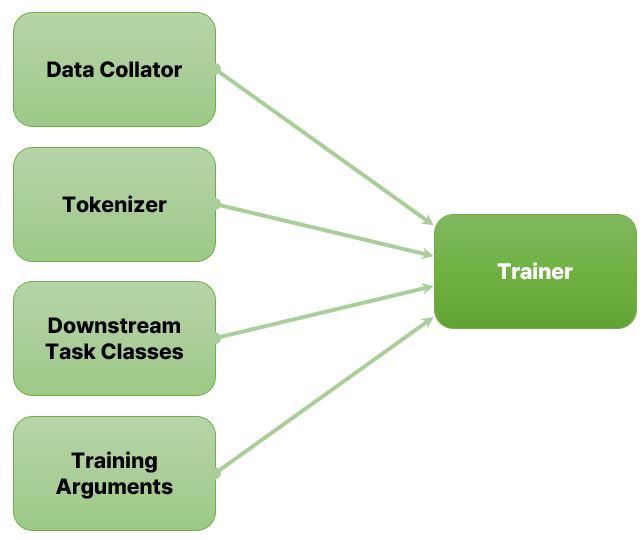

### 토크나이저 로딩

In [11]:
from transformers import AutoTokenizer

In [12]:
model_name = "monologg/koelectra-base-v3-discriminator"

In [13]:
# 사전학습된 모델의 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces = True)

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [14]:
# 한개 뉴스 제목 토큰화 테스트
temp_result = tokenizer(
    raw_datasets["train"][0]["title"],
    truncation = True,
    max_length = 128
)

In [15]:
temp_result

{'input_ids': [2, 11468, 11642, 22, 4366, 4149, 4200, 32462, 6310, 6800, 6411, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
# 토크나이저 함수 정의
def tokenize_function(example) :
    return tokenizer(example["title"], truncation = True, max_length = 128)

- 토크나이저 함수를 데이터셋에 적용

> map() : 변환을 호출하는 즉시 적용

> with_transform() : 변환을 등록, 데이터에 대해 실제로 접근했을 때 변환을 적용 (스트림 형)


In [17]:
# 사용자 함수 적용
tokenized_datasets = raw_datasets.map(
    tokenize_function, # 처리할 함수 적용
    batched = True     # 속도향상, GPU 자원이 있는 경우 배치 내 데이터들을 한꺼번에 padding/truncation을 수행
)

Map:   0%|          | 0/45678 [00:00<?, ? examples/s]

Map:   0%|          | 0/9107 [00:00<?, ? examples/s]

In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9107
    })
})

In [19]:
# 학습에 불필요한 컬럼(필드) 삭제
remove_columns = [ key for key in raw_datasets["train"].features.keys() if key != "label" ]

In [20]:
tokenized_datasets = tokenized_datasets.remove_columns(remove_columns)

In [21]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9107
    })
})

### 사전 학습 모델 로드 (Downstream Task Classes)
- 라벨에 대해 해석하기 쉽게 레이블 이름도 미리 등록

In [22]:
# 라벨명 추출
label_names = tokenized_datasets["train"].features["label"].names

In [23]:
# 매핑용 사전
id2label = { i:name for i, name in enumerate(label_names) }
label2id = { name:i for i, name in enumerate(label_names) }

In [24]:
id2label, label2id

({0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'},
 {'IT과학': 0, '경제': 1, '사회': 2, '생활문화': 3, '세계': 4, '스포츠': 5, '정치': 6})

In [108]:
from transformers import AutoModelForSequenceClassification

In [109]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = len(label_names))

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model.config.id2label, model.config.label2id

({0: 'LABEL_0',
  1: 'LABEL_1',
  2: 'LABEL_2',
  3: 'LABEL_3',
  4: 'LABEL_4',
  5: 'LABEL_5',
  6: 'LABEL_6'},
 {'LABEL_0': 0,
  'LABEL_1': 1,
  'LABEL_2': 2,
  'LABEL_3': 3,
  'LABEL_4': 4,
  'LABEL_5': 5,
  'LABEL_6': 6})

In [28]:
# 라벨명 매핑(사전 등록)
model.config.id2label = id2label
model.config.label2id = label2id

In [29]:
model.config.id2label

{0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}

### Data Collator
- 배치별로 데이터를 Trainer에게 전달해주는 클래스
- 패딩이 자동으로 적용됨

> 평가지표 함수
> - 정확도, 정밀도, 재현율, F1 활용

In [30]:
from transformers import DataCollatorWithPadding
# 동적으로 최장 길이(128)에 맞춰 패딩을 수행한 이후, Trainer에게 전달

In [31]:
# 초기화
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

### 평가 지표 함수 만들기 전에, Test

In [32]:
model = model.to(device)

In [33]:
# 검증셋에서 샘플 가져오기
sample = tokenized_datasets["validation"][0]

In [34]:
# 사용할 필드명
use_columns = [ key for key in tokenized_datasets["validation"].features.keys() if key != "label"]

In [35]:
# 모델에 입력 변환 작업
inputs = {}

for key, value in sample.items() :
    if key in use_columns :
        tensor = torch.tensor(value)
        tensor = tensor.unsqueeze(0)
        tensor = tensor.to(device)

        inputs[key] = tensor

In [36]:
# 정답 레이블 변환
label = sample["label"]
label_tensor = torch.tensor([label])
label_tensor = label_tensor.to(device)
label_tensor

tensor([2], device='cuda:0')

In [37]:
inputs

{'input_ids': tensor([[    2,    25,  4639,  4005, 23362, 18075,  4034,  2411,  4219,    27,
           4156,  4172,  4005,  6874,  4164,  4034,  3081,  4880,  4176,     3]],
        device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
        device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0')}

In [38]:
# 예측

with torch.no_grad() :
    outputs = model(**inputs)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [40]:
import warnings
warnings.filterwarnings("ignore") # 경고메세지 무시, 다시 활성화 == default

In [41]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0278, -0.0051,  0.0066, -0.0028, -0.0220, -0.0505,  0.0008]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [42]:
import numpy as np

In [46]:
logits = outputs.logits.cpu().numpy()

In [51]:
pred = np.argmax(logits)

print(f"예측값 : {model.config.id2label[ pred ]}")
print(f"실제값 : {model.config.id2label[ label_tensor.item() ]}")

예측값 : 사회
실제값 : 사회


In [53]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [55]:
labels = label_tensor.cpu().numpy()

In [58]:
preds = np.array([pred])

In [59]:
# 정확도 계산
accuracy_score(labels, preds)

1.0

In [63]:
# 정밀도, 재현율, f1score 계산
prec, rec, f1, _ = precision_recall_fscore_support(
    labels,
    preds,
    average = "macro", # 각 클래스별 평가지표 결과를 동일한 비중으로 평균값으로 반환
    zero_division = 0 # 분모가 0이 되는 경우 -> 결과를 0으로 처리
)
prec, rec, f1, _

(1.0, 1.0, 1.0, None)

- Trainer 에게 전달할 평가지표 함수 정의

In [64]:
def compute_metrics(eval_pred) :
    # eval_pred : (logits, labels)

    logits, labels = eval_pred
    preds = np.argmax(logits, axis = 1)

    # 정확도, 정밀도, 재현율, f1score
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average = "macro", zero_division = 0)

    return {"accuracy":acc,
            "precision":prec,
            "recall":rec,
            "f1":f1}

### Training Arguments 설정

In [65]:
batch_size = 64

In [66]:
from transformers import TrainingArguments

In [69]:
# 초기화
training_args = TrainingArguments(
    output_dir = "./data/ynat-model", # 학습 결과 어디다가 저장할건지?
    num_train_epochs = 3,             # 에폭수
    per_device_train_batch_size = batch_size, # 학습 시 사용할 배치 크기
    per_device_eval_batch_size = batch_size, # 검증 시 배치크기
    learning_rate = 5e-5,               # 0.00005
                                        # 보통 Adam 사용 - 기본 학습률은 0.001
                                        # - FineTuning에서 최소 10배에서 100배 정도 적게 설정
    eval_strategy = "epoch",            # epoch 끝날 때마다 검증
    logging_steps = 50,                 # 학습 중간에 로그를 찍는 간격 (Step)
    save_strategy = "epoch",            # epoch 끝날 때마다 저장
    load_best_model_at_end = True,      # 최적의 가중치로 마지막 학습 결과를 업데이트
    metric_for_best_model = "accuracy", # 최고 모델 판단 기준
    push_to_hub = False,                # 모델을 수동으로 push(저장)
    report_to = "none"                  # W&B(로그 수집하는 기업) 비활성화
)

### Trainer 초기화 & Fine-Tuning

In [70]:
from transformers import Trainer

In [72]:
# 초기화
trainer = Trainer(
    model = model, # 다운스트림 적용할 모델
    args = training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    data_collator = data_collator,
    processing_class = tokenizer, # 25년 5월 전까지는 tokenizer 인자값
    compute_metrics = compute_metrics # 평가지표 함수
)

In [73]:
# 학습
trainer.train() # fit() 과 비슷

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.402500,0.453981,0.843856,0.823740,0.874167,0.845498
2,0.292000,0.392822,0.859229,0.850821,0.868020,0.858486
3,0.219800,0.417466,0.859559,0.847508,0.873653,0.859764


TrainOutput(global_step=2142, training_loss=0.3650749471007275, metrics={'train_runtime': 634.9237, 'train_samples_per_second': 215.827, 'train_steps_per_second': 3.374, 'total_flos': 1616745095802300.0, 'train_loss': 0.3650749471007275, 'epoch': 3.0})

### 평가, 성능분석
- 검증 데이터(원래는 평가용 별도로 준비)에 대해서 최종 성능 확인
- 혼돈행렬

In [74]:
# 검증셋에 대한 최종 평가
metrics = trainer.evaluate()
metrics

{'eval_loss': 0.4174655079841614,
 'eval_accuracy': 0.8595585813110794,
 'eval_precision': 0.8475076717576719,
 'eval_recall': 0.8736525323975258,
 'eval_f1': 0.859763518878746,
 'eval_runtime': 12.889,
 'eval_samples_per_second': 706.571,
 'eval_steps_per_second': 11.095,
 'epoch': 3.0}

- 혼돈행렬을 통해서 어떤 토픽(라벨)에서 오분류가 발생하는지 관측

In [75]:
from sklearn.metrics import confusion_matrix

In [76]:
# 예측 객체
pred_results = trainer.predict(tokenized_datasets["validation"])
pred_results

PredictionOutput(predictions=array([[-0.7624845 ,  5.6785436 ,  1.1956284 , ..., -2.1612396 ,
        -2.8146358 , -2.4734092 ],
       [ 2.2326908 ,  0.13647686,  4.430277  , ..., -3.124387  ,
        -3.473765  , -0.7591232 ],
       [ 5.324203  , -0.47724745,  0.27217737, ..., -1.1499618 ,
        -1.5196939 , -2.3979125 ],
       ...,
       [-0.8110302 ,  5.499788  ,  1.3393756 , ..., -2.5265694 ,
        -2.402905  , -3.1159832 ],
       [-2.529042  , -2.2381816 ,  4.557024  , ..., -2.9659832 ,
        -1.7634984 ,  1.7883813 ],
       [ 1.2164612 , -1.2158902 ,  4.6338267 , ..., -3.1627162 ,
        -1.976335  , -2.4447951 ]], dtype=float32), label_ids=array([2, 2, 0, ..., 1, 2, 2]), metrics={'test_loss': 0.4174655079841614, 'test_accuracy': 0.8595585813110794, 'test_precision': 0.8475076717576719, 'test_recall': 0.8736525323975258, 'test_f1': 0.859763518878746, 'test_runtime': 13.4177, 'test_samples_per_second': 678.731, 'test_steps_per_second': 10.658})

In [84]:
# 예측값
y_pred = np.argmax(pred_results.predictions, axis = 1)

In [85]:
# 실제값
y_true = pred_results.label_ids

In [91]:
y_pred, y_true

(array([1, 2, 0, ..., 1, 2, 2]), array([2, 2, 0, ..., 1, 2, 2]))

In [93]:
cm = confusion_matrix(y_true, y_pred)

In [94]:
cm

array([[ 457,   26,   52,    7,    7,    5,    0],
       [  31, 1178,  108,   11,   12,    6,    2],
       [  74,  215, 3087,  156,   38,   29,  102],
       [  21,   25,   99, 1183,   20,   15,    6],
       [   7,   15,   14,   25,  748,   14,   12],
       [   0,    2,    3,    2,    4,  566,    1],
       [   0,    2,   92,    2,   12,    5,  609]])

In [95]:
# 시각화
import matplotlib.pyplot as plt

plt.rc("font", family = "Gulim")
plt.rc("axes", unicode_minus = False)

In [100]:
# 라벨 명칭 리스트 생성
lable_names = list(model.config.label2id.keys())
label_names

['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']

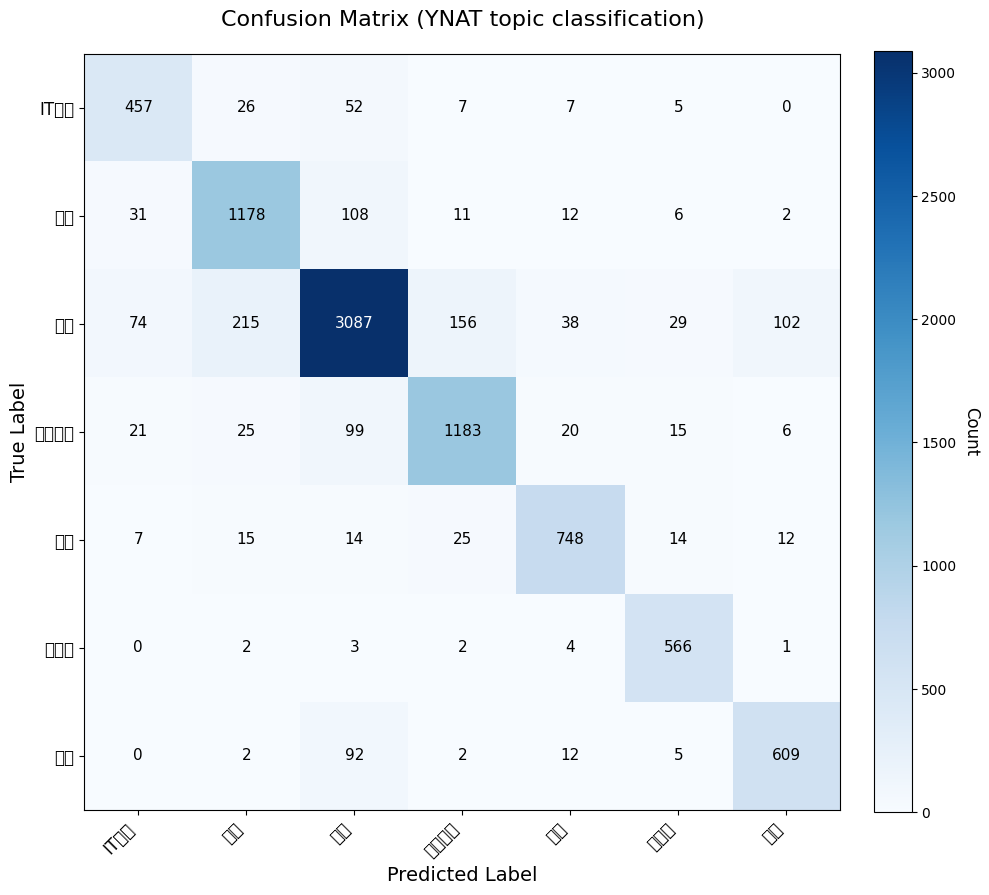

In [101]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, cmap='Blues')
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Count', rotation=-90, va="bottom", fontsize=12)

n = len(label_names)
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(label_names, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels(label_names, fontsize=12)

ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)
ax.set_title("Confusion Matrix (YNAT topic classification)", fontsize=16, pad=20)

threshold = cm.max() / 2
for i in range(n):
    for j in range(n):
        color = "white" if cm[i, j] > threshold else "black"
        ax.text(j, i, cm[i, j], ha="center", va="center", color=color, fontsize=11)

plt.tight_layout()
plt.show()

In [102]:
trainer

### 허깅페이스 허브에 모델 업로드하기

In [ ]:
!huggingface-cli login

In [114]:
kwargs = {"finetuned_from" : model.config._name_or_path,
          "tasks" : ["text-classificaion"],
          "dataset":["klue-ynat"],
          "tags":["text-classification", "KoELECTRA", "Korean-NLP", "topic-classification", "news-classification"],
          "language" : ["ko"]} # 모델이 지원하는 언어 - ISO 코드 지정

In [115]:
# 저장 - 메타데이터 정보
trainer.push_to_hub("bongbongbong/news-classifier", **kwargs)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ss 2)/tmp_trainer/training_args.bin: 100%|##########| 5.37kB / 5.37kB            

CommitInfo(commit_url='https://huggingface.co/bongbongbong/tmp_trainer/commit/b84641a5a38179dd9cf3cd018860d4fa946dbd9a', commit_message='bongbongbong/news-classifier', commit_description='', oid='b84641a5a38179dd9cf3cd018860d4fa946dbd9a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bongbongbong/tmp_trainer', endpoint='https://huggingface.co', repo_type='model', repo_id='bongbongbong/tmp_trainer'), pr_revision=None, pr_num=None)

In [110]:
model.config._name_or_path

'monologg/koelectra-base-v3-discriminator'

In [116]:
from transformers import pipeline

In [117]:
# 저장소에 있는 모델 불러다가 사용
clasifier = pipeline(task = "text-classification", model = "bongbongbong/ynat-model")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [118]:
clasifier("손흥민 선수, 어제 경기에서 두골 기록하며 팀 승리 견인")

[{'label': '스포츠', 'score': 0.9981604218482971}]